A notebook for capturing calibration data for the cameras of the OROCHI Simualtor of the Kameda Lab.

# Process Overview

The objective of this notebook is to capture uniformly illuminated and dark images (across the sampling area) that can be used to characterise each camera of the OROCHI simulator, in terms of:
- Linearity
- Read Noise
- Gain
- FPN
- Dark Signal

To do this, we will  capture images of the 99% Reflectance Spectralon Calibration Target (SCT99) and the 5% Reflectance Spectral Calibration Target (SCT5), and images without illumination, at exposures that range from the minimum possible with the cameras (~5 µs) up to a maximum, defined such that all pixels of the image are saturated (DN=255).

For each exposure, we will capture:
- 2 illuminated images of the target
- 25 dark images (to reduce read noise by factor of 5)

We will choose exposures with the following procedure:
1. Start at minimum exposure - capture pair, record exposure
2. Double exposure - capture pair, record exposure
3. Repeat until all pixels are saturated - i.e. all = 255
4. Reduce exposure by factor of 0.90, and repeat, until 0 pixels are saturated.

This process will be repeated for SCT99 and SCT5, and then again for dark images.
Then, 25 dark frames will be captured for each exposure, and the mean and standard deviation TIFF float images recorded.


# Camera Setup

Here we configure and setup the camera capture objects.

In [22]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
import orochi_sim_ctrl as osc

ic = osc.start_ic()
camera_config = osc.load_camera_config()
cameras = osc.connect_cameras(ic, camera_config)
osc.configure_cameras(cameras)

Device 0 (DMK 33GX249 10910288) succesfully connected.
Device 1 (DMK 33GX249 10910273) succesfully connected.
Device 3 (DMK 33GX249 10910294) succesfully connected.
Device 4 (DMK 33GX249 10910291) succesfully connected.
Device 5 (DMK 33GX249 10910295) succesfully connected.
Device 7 (DMK 33GX249 23120778) succesfully connected.
Device 6 (DMK 33GX249 10910265) succesfully connected.
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
1
Video Format set to : Y16 (1920x1200)
1
Sink Format set to : "SinkFormats.Y16"
Frame Rate set to : 30.0 FPS
Brightness Value set to 128
Contrast Value set to 0
Sharpness Value set to 0
Gamma Value set to 100
Gain Value set to 0.0
Gain Auto set to 0
Exposure Value set to 0.009999999776482582
Exposure Auto set to 1
Exposure Auto Reference set to 80
Exposure Auto Max Value set to 10.0
Exposure Auto Max Auto set to 0
Trigger Enable set to 0
Denoise Value set to 0
Flip Horizontal Enable set to 0
Flip Vertical

In [26]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

Here we are only going to process images over the calibration target itself, so we restrict the ROI to a very small field of 32x32 pixels.
Statistics are therfore computed over 1024 pixels in each case.

DMK 33GX249 10910288
Imaging with Exposure: 0.015625 s
+Good exposure 0.015625 Image recieved
x: 565
y: 679


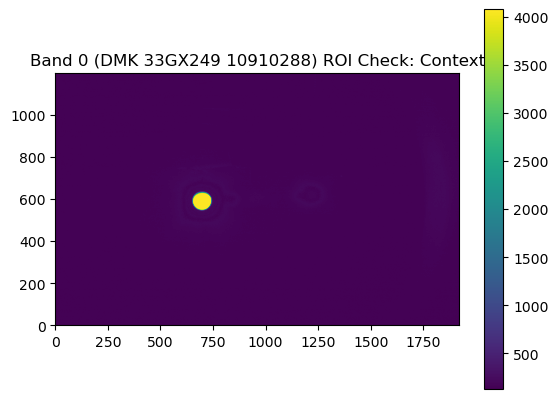

Imaging with Exposure: 0.3242180049419403 s
+Good exposure 0.3242180049419403 Image recieved


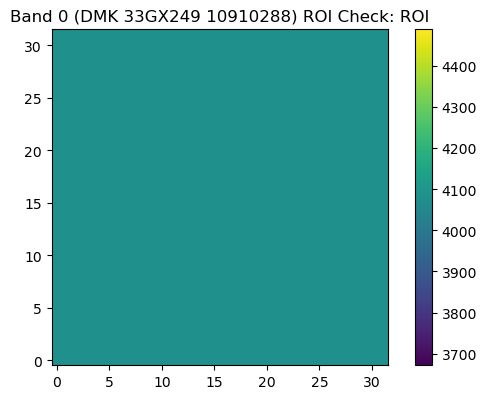

DMK 33GX249 10910273
Imaging with Exposure: 0.015625 s
+Good exposure 0.015625 Image recieved
x: 873
y: 945


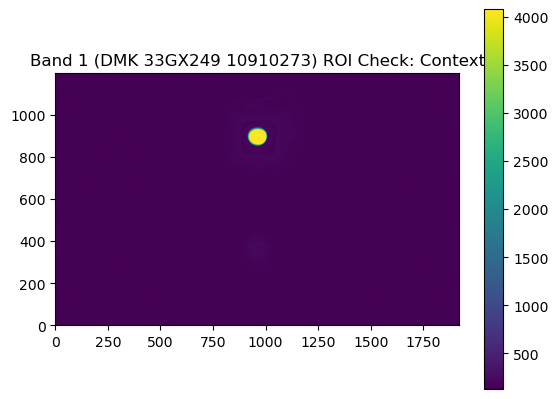

Imaging with Exposure: 0.015625 s
+Good exposure 0.015625 Image recieved


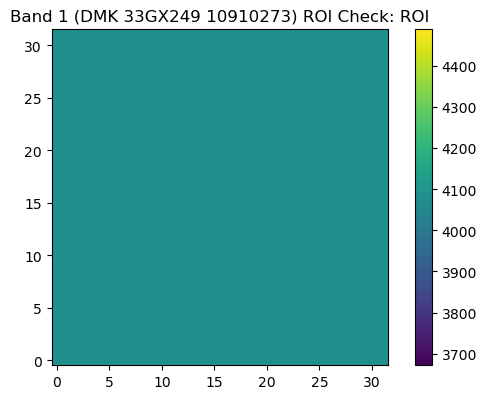

DMK 33GX249 10910294
Imaging with Exposure: 0.015625 s
+Good exposure 0.015625 Image recieved
x: 880
y: 673


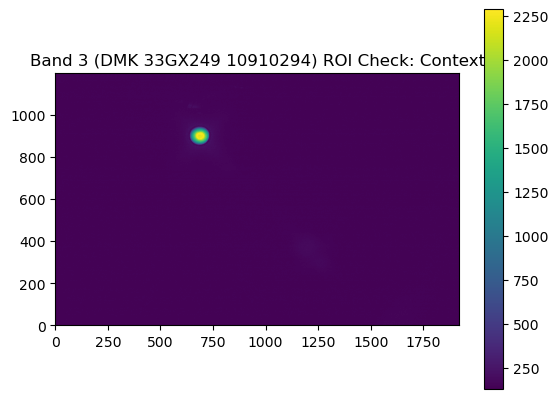

Imaging with Exposure: 0.015625 s
+Good exposure 0.015625 Image recieved


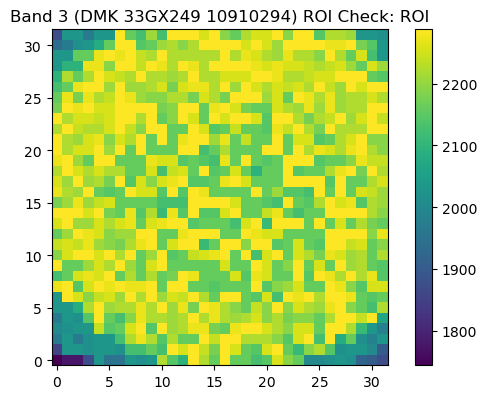

DMK 33GX249 10910291
Imaging with Exposure: 0.015625 s
+Good exposure 0.015625 Image recieved
x: 577
y: 1231


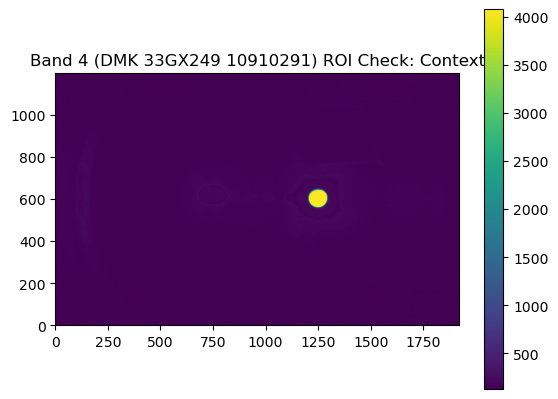

Imaging with Exposure: 0.3242180049419403 s
+Good exposure 0.3242180049419403 Image recieved


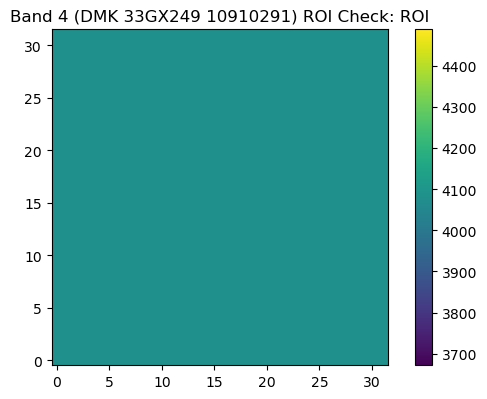

DMK 33GX249 10910295
Imaging with Exposure: 0.015625 s
+Good exposure 0.015625 Image recieved
x: 244
y: 694


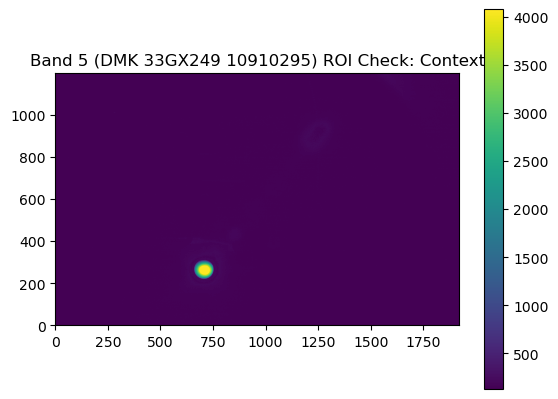

Imaging with Exposure: 0.015625 s
+Good exposure 0.015625 Image recieved


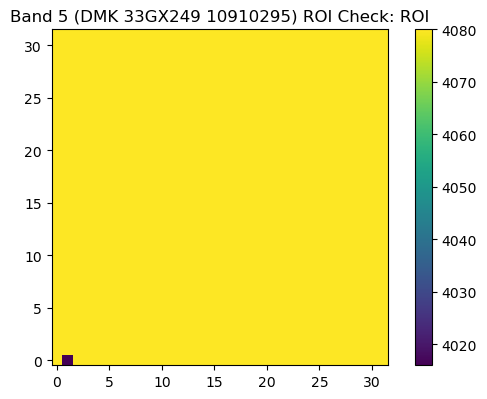

DMK 33GX249 23120778
Imaging with Exposure: 0.009998999536037445 s
+Good exposure 0.009998999536037445 Image recieved
x: 236
y: 964


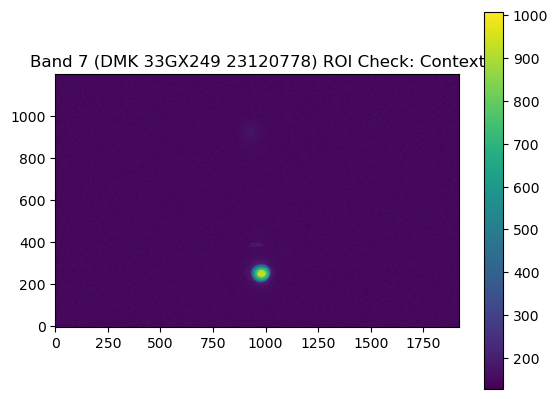

Imaging with Exposure: 0.009998999536037445 s
+Good exposure 0.009998999536037445 Image recieved


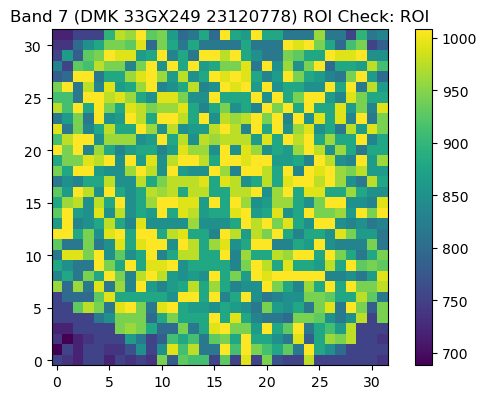

DMK 33GX249 10910265
Imaging with Exposure: 0.015625 s
+Good exposure 0.015625 Image recieved
x: 874
y: 1231


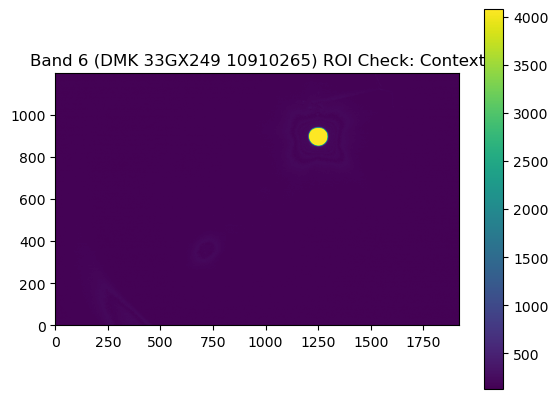

Imaging with Exposure: 0.3242180049419403 s
+Good exposure 0.3242180049419403 Image recieved


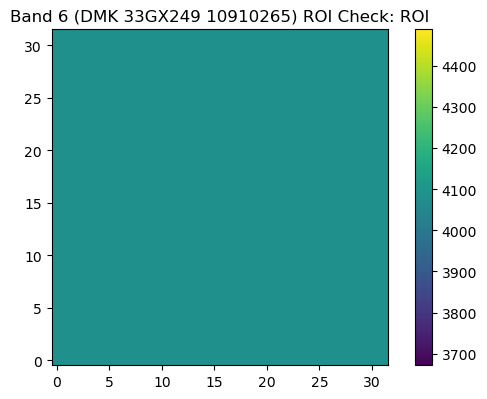

In [27]:
osc.find_camera_rois(cameras, roi_size=32)

# Calibration Functions

Here we define simple functions for controlling the cameras during the calibration routines.

In [33]:
def camera_calibration_sequence(camera, subject) -> pd.DataFrame:
    """Capture pairs of images with increasing exposure time until all
    pixels are saturated, then decrease exposure time until no pixels are 
    saturated.
    
    Args:
        camera: Camera object to capture images from.
    
    Returns:
        DataFrame with columns:
            - exposure
            - mean
            - std
    """
    camera.set_property('Exposure', 'Auto', 0, 'Switch')        
    t_min = 1.0/16666 # (seconds) verify that this is the minimum exposure time
    t_max = 5.0
    t_exp = t_min
    up_scale = 1.1
    dwn_scale = 0.99
    t_scale = up_scale
    img_type='calibration'
    stop = False    
    cmd_exposures = []
    exposures = []
    means = []
    stds = []
    shots = []
    sat_val = 4080
    while stop is False:
        print(f'Exposure: {t_exp:.7f} s')
        camera.set_property('Exposure', 'Value', t_exp, 'AbsoluteValue')
        img_1 = camera.image_capture(roi=True)
        img_2 = camera.image_capture(roi=True)
        name_1 = f'{t_exp*1E6:.0f}us_1'
        name_2 = f'{t_exp*1E6:.0f}us_2'
        camera.save_image(name_1, subject, img_type, img_1)
        camera.save_image(name_2, subject, img_type, img_2)
        exposures.append(camera.get_exposure_value())
        cmd_exposures.append(t_exp)
        mean = np.mean([np.mean(img_1), np.mean(img_2)])
        std = np.mean([np.std(img_1), np.std(img_2)])
        shot = np.sqrt(np.mean((img_1 - img_2)**2)/2)
        means.append(mean)
        stds.append(std)
        shots.append(shot)
        print(mean)
        if mean >= sat_val * 0.999:
            t_scale = dwn_scale
        if t_scale == dwn_scale:
            n_sat = (np.sum(img_1 == sat_val) + np.sum(img_2 == sat_val)) / 2
            if n_sat == 0 and std != 0.0:
                stop = True
        else:
            if t_exp*t_scale > t_max:
                t_scale = dwn_scale
        t_exp = t_exp * t_scale

    results = pd.DataFrame({'exposure': exposures, 'raw mean': means, 'raw standard deviation': stds, 'shot and read noise': shots})
    results.sort_values('exposure', inplace=True)

    print(results)

    cwl_str = str(int(camera.camera_props['cwl']))
    channel = str(camera.camera_props['number'])+'_'+cwl_str
    subject_dir = Path('..', 'data', subject, channel)
    subject_dir.mkdir(parents=True, exist_ok=True)
    filename = 'exposures.csv'
    img_file =str(Path(subject_dir, filename).with_suffix('.tif'))

    results['exposure'].to_csv(f'{subject}_exposures.csv', index=False)

    fig, ax = plt.subplots(2,1, figsize=(5,10))
    ax[0].plot(results['exposure'], results['raw mean'])
    ax[0].set_xlabel('Exposure (s)')
    ax[0].set_ylabel('Mean Pixel Value')
    results.sort_values('raw mean', inplace=True)
    ax[1].loglog(results['raw mean'], results['raw standard deviation'], label='Total Noise')
    ax[1].loglog(results['raw mean'], results['shot and read noise'], label='Shot and Read Noise')
    ax[1].set_xlabel('Mean Pixel Value')
    ax[1].set_ylabel('Standard Deviation')
    plt.show()
    return cmd_exposures

# SCT99 Procedure

Output:
- SCT99 Exposure List
- SCT99 Lit Image Directory

Exposure Auto set to 0
Exposure: 0.0000600 s
Exposure Value set to 6.000239955028519e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\SCT99\0_650\650_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\SCT99\0_650\650_60us_2_calibration.tif
199.5
Exposure: 0.0000660 s
Exposure Value set to 6.6002641688101e-05
Imaging with Exposure: 6.600000051548705e-05 s
+Good exposure 6.600000051548705e-05 Image recieved
Imaging with Exposure: 6.600000051548705e-05 s
+Good exposure 6.600000051548705e-05 Image recieved
Exposure current Value: 6.600000051548705e-05
Image 66us_1 written to ..\data\SCT99\0_650\650_66us_1_calibration.tif
Exposure current Value: 6.600000051548705e-05
Image 66us_2 written to ..\data\SCT99\0_650\650_

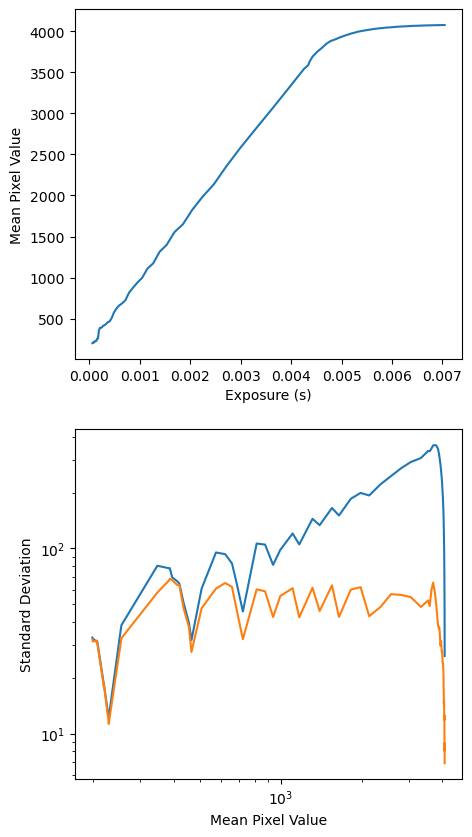

Exposure Auto set to 0
Exposure: 0.0000600 s
Exposure Value set to 6.000239955028519e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\SCT99\1_475\475_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\SCT99\1_475\475_60us_2_calibration.tif
183.828125
Exposure: 0.0000660 s
Exposure Value set to 6.6002641688101e-05
Imaging with Exposure: 6.600000051548705e-05 s
+Good exposure 6.600000051548705e-05 Image recieved
Imaging with Exposure: 6.600000051548705e-05 s
+Good exposure 6.600000051548705e-05 Image recieved
Exposure current Value: 6.600000051548705e-05
Image 66us_1 written to ..\data\SCT99\1_475\475_66us_1_calibration.tif
Exposure current Value: 6.600000051548705e-05
Image 66us_2 written to ..\data\SCT99\1_475

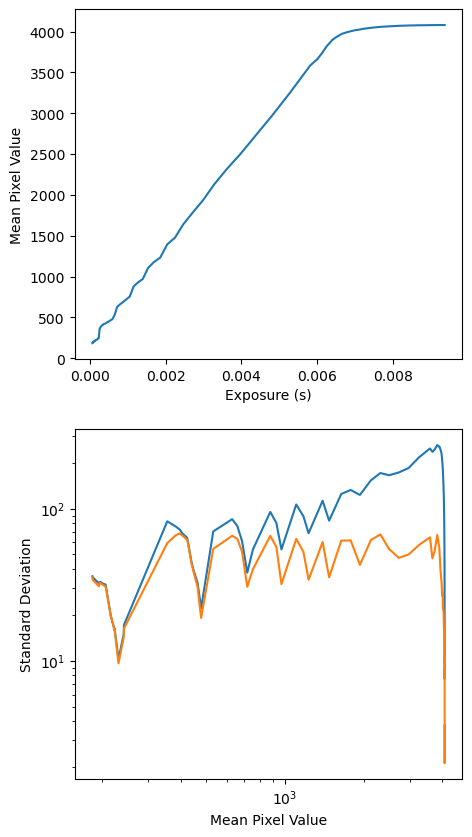

Exposure Auto set to 0
Exposure: 0.0000600 s
Exposure Value set to 6.000239955028519e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\SCT99\3_400\400_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\SCT99\3_400\400_60us_2_calibration.tif
210.9921875
Exposure: 0.0000660 s
Exposure Value set to 6.6002641688101e-05
Imaging with Exposure: 6.600000051548705e-05 s
+Good exposure 6.600000051548705e-05 Image recieved
Imaging with Exposure: 6.600000051548705e-05 s
+Good exposure 6.600000051548705e-05 Image recieved
Exposure current Value: 6.600000051548705e-05
Image 66us_1 written to ..\data\SCT99\3_400\400_66us_1_calibration.tif
Exposure current Value: 6.600000051548705e-05
Image 66us_2 written to ..\data\SCT99\3_40

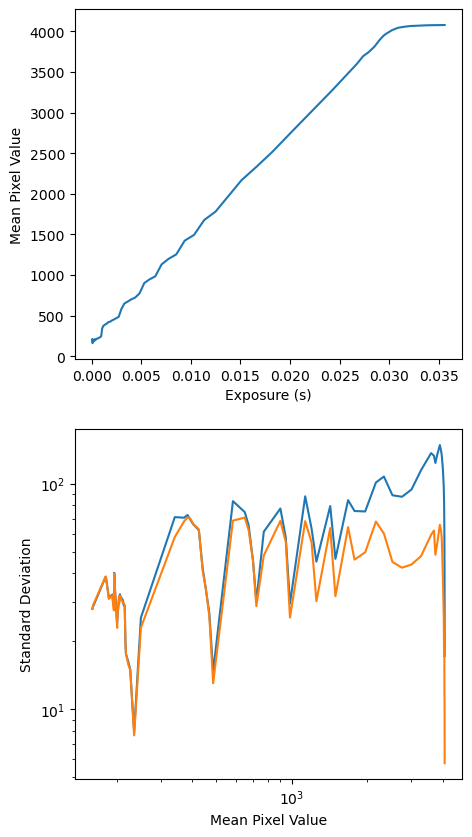

Exposure Auto set to 0
Exposure: 0.0000600 s
Exposure Value set to 6.000239955028519e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\SCT99\4_725\725_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\SCT99\4_725\725_60us_2_calibration.tif
203.28125
Exposure: 0.0000660 s
Exposure Value set to 6.6002641688101e-05
Imaging with Exposure: 6.600000051548705e-05 s
+Good exposure 6.600000051548705e-05 Image recieved
Imaging with Exposure: 6.600000051548705e-05 s
+Good exposure 6.600000051548705e-05 Image recieved
Exposure current Value: 6.600000051548705e-05
Image 66us_1 written to ..\data\SCT99\4_725\725_66us_1_calibration.tif
Exposure current Value: 6.600000051548705e-05
Image 66us_2 written to ..\data\SCT99\4_725\

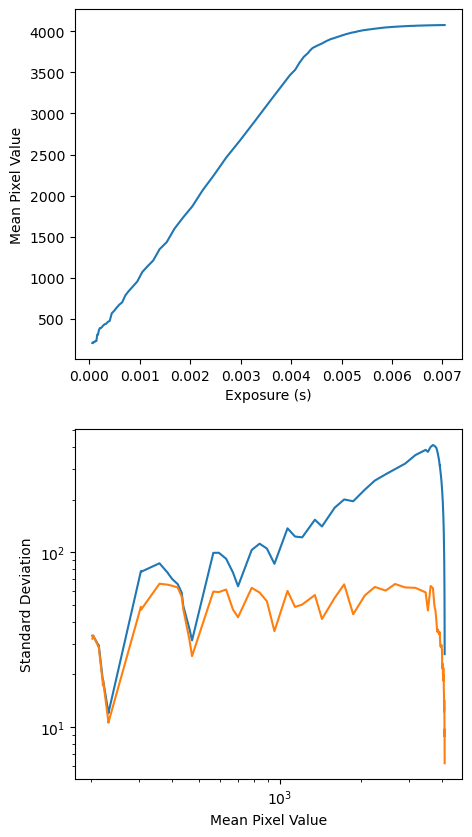

Exposure Auto set to 0
Exposure: 0.0000600 s
Exposure Value set to 6.000239955028519e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\SCT99\5_850\850_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\SCT99\5_850\850_60us_2_calibration.tif
2096.6640625
Exposure: 0.0000660 s
Exposure Value set to 6.6002641688101e-05
Imaging with Exposure: 6.600000051548705e-05 s
+Good exposure 6.600000051548705e-05 Image recieved
Imaging with Exposure: 6.600000051548705e-05 s
+Good exposure 6.600000051548705e-05 Image recieved
Exposure current Value: 6.600000051548705e-05
Image 66us_1 written to ..\data\SCT99\5_850\850_66us_1_calibration.tif
Exposure current Value: 6.600000051548705e-05
Image 66us_2 written to ..\data\SCT99\5_8

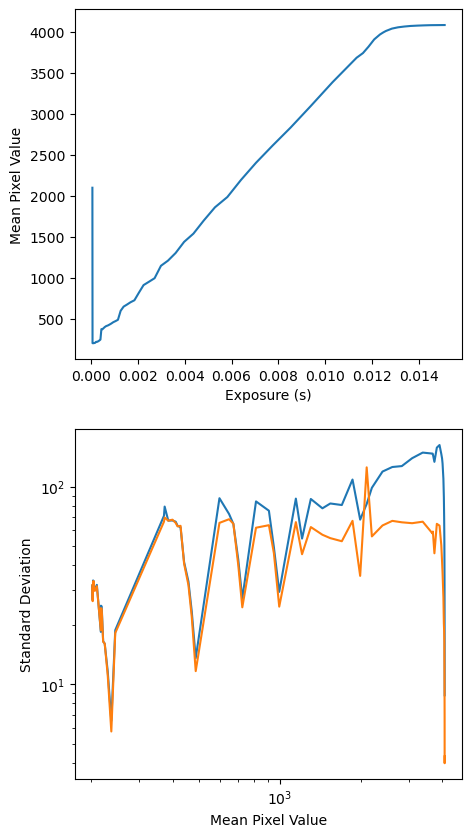

Exposure Auto set to 0
Exposure: 0.0000600 s
Exposure Value set to 6.000239955028519e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\SCT99\7_950\950_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\SCT99\7_950\950_60us_2_calibration.tif
183.125
Exposure: 0.0000660 s
Exposure Value set to 6.6002641688101e-05
Imaging with Exposure: 6.600000051548705e-05 s
+Good exposure 6.600000051548705e-05 Image recieved
Imaging with Exposure: 6.600000051548705e-05 s
+Good exposure 6.600000051548705e-05 Image recieved
Exposure current Value: 6.600000051548705e-05
Image 66us_1 written to ..\data\SCT99\7_950\950_66us_1_calibration.tif
Exposure current Value: 6.600000051548705e-05
Image 66us_2 written to ..\data\SCT99\7_950\95

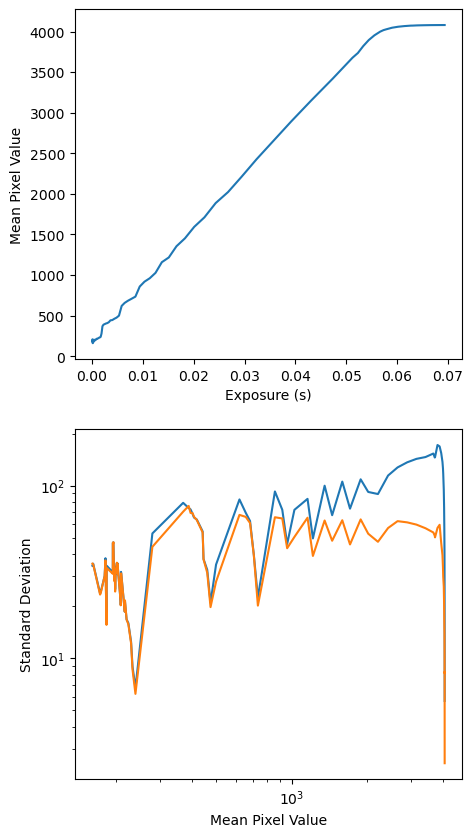

Exposure Auto set to 0
Exposure: 0.0000600 s
Exposure Value set to 6.000239955028519e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\SCT99\6_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\SCT99\6_550\550_60us_2_calibration.tif
220.078125
Exposure: 0.0000660 s
Exposure Value set to 6.6002641688101e-05
Imaging with Exposure: 6.600000051548705e-05 s
+Good exposure 6.600000051548705e-05 Image recieved
Imaging with Exposure: 6.600000051548705e-05 s
+Good exposure 6.600000051548705e-05 Image recieved
Exposure current Value: 6.600000051548705e-05
Image 66us_1 written to ..\data\SCT99\6_550\550_66us_1_calibration.tif
Exposure current Value: 6.600000051548705e-05
Image 66us_2 written to ..\data\SCT99\6_550

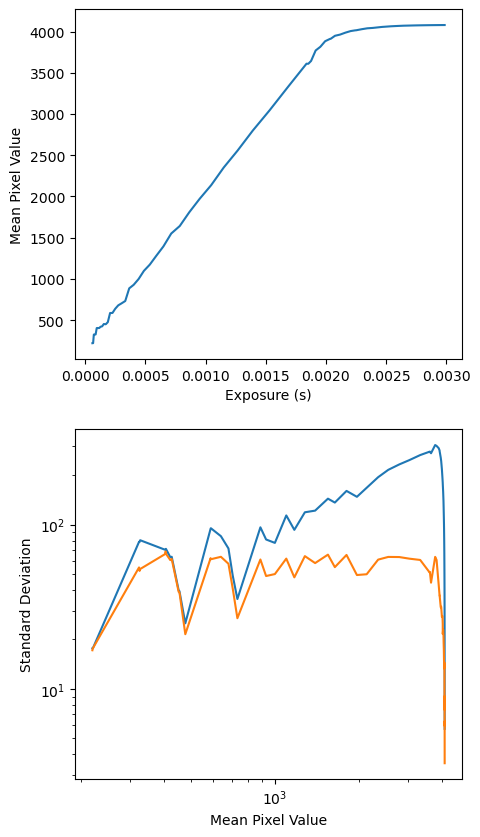

In [34]:
sct99_exposures = {}
for camera in cameras:
    sct99_exposures[camera] = camera_calibration_sequence(camera, 'SCT99')

# SCT5 Procedure

Output:
- SCT5 Exposure List
- SCT5 Lit Image Directory

In [ ]:
sct5_exposures = {}
for camera in cameras:
    sct5_exposures[camera] = camera_calibration_sequence(camera, 'SCT5')

# Dark Signal Procedure

Output:
- Dark Exposure List
- Dark Image Directory

In [ ]:
for camera in cameras:
    dark_exposures = camera_calibration_sequence(camera, 'dark_20dB')

# Dark Frame Capture

Output:
- addition of dark mean frames to SCT99 directory
- addition of dark mean frames to SCT5 directory

In [ ]:
for camera in cameras:
    exposures = sct99_exposures[camera]
    for exposure in exposures:
        camera.set_property('Exposure', 'Value', exposure, 'AbsoluteValue')
        drk = camera.image_capture(roi=True)
        for i in range(24):
            drk += camera.image_capture(roi=True)
        drk_ave = drk.astype(np.float32)/25
        name = f'{exposure*1E6:.0f}us_d'
        camera.save_image(name, 'SCT99', 'drk', drk_ave)

In [ ]:
for camera in cameras:
    exposures = sct5_exposures[camera]
    for exposure in exposures:
        camera.set_property('Exposure', 'Value', exposure, 'AbsoluteValue')
        drk = camera.image_capture(roi=True)
        for i in range(24):
            drk += camera.image_capture(roi=True)
        drk_ave = drk.astype(np.float32)/25
        name = f'{exposure*1E6:.0f}us_d'
        camera.save_image(name, 'SCT5', 'drk', drk_ave)